In [1]:
import tensorflow as tf
import numpy as np
import random, json, string, pickle
import keras
import keras.layers
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import keras.models
from keras.models import Sequential
import keras.optimizers
import keras.callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

import keras.applications.vgg16 as vgg16

Using TensorFlow backend.


In [2]:
# def VGG_16(weights_path=None):
#     model = Sequential()
#     model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
#     model.add(Convolution2D(64, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(64, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(256, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(256, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(256, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(512, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1000, activation='sigmoid'))

#     if weights_path:
#         model.load_weights(weights_path)

#     return model

In [2]:
# m = vgg16.VGG16(weights='imagenet')
# m.layers.pop()
# m.layers.append(Dense(1000, activation='sigmoid'))
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# m.compile(loss='binary_crossentropy', optimizer = adam, metrics=['accuracy'])
# m.summary()

# get the pretrained model (minus FC layers)
original_model = vgg16.VGG16(weights='imagenet', include_top=False, input_tensor = vgg16.Input(shape=(224,224,3)))

# freeze conv layers
for layer in original_model.layers:
    layer.trainable = False
    #pass

# construct model
deep_features = Flatten()(original_model.output)
#fc1 = Dense(10, activation="relu")(deep_features)
ingredients_guessing = Dense(1000, activation='sigmoid')(deep_features)#fc1)
m = keras.models.Model(input=original_model.input, output=ingredients_guessing)

print(m.summary())

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=True)
#optimizer = Adam()
m.compile(optimizer, loss='binary_crossentropy')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  0           input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [ ]:
# m = VGG_16()
# #sgd = keras.optimizers.SGD(lr = 0.01, decay = 1e-2, momentum = 0.9)
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# m.compile(loss='binary_crossentropy', optimizer = adam, metrics=['accuracy'])
# m.summary()

Creating the Pantry

In [10]:
conn = sqlite3.connect("yummly.db")
recipes = conn.execute("SELECT ID, CleanIngredients FROM Recipe WHERE ImageAvailable=1;").fetchall()
conn.close()

In [11]:
def prepIngredients(ingredients_string):
    return [x.strip() for x in ingredients_string.split(";")]

recipes = [tuple([x[0], prepIngredients(x[1])])for x in recipes]

In [12]:
all_ingredients = np.array([item for sublist in recipes for item in sublist[1]])
unique_ing = np.unique(all_ingredients, return_counts = True)

argsort_results = np.argsort(unique_ing[1])

sorted_ing = unique_ing[0][argsort_results]
sorted_vals = unique_ing[1][argsort_results]
sorted_ing = sorted_ing[::-1]

id2food = sorted_ing[0:1000]
food2id = {food: idx[0] for idx, food in np.ndenumerate(id2food)}



In [13]:
id2food[169]

'quinoa'

In [14]:
# free up some memory
all_ingredients = None
argsort_results = None
sorted_vals = None

In [15]:
ids = [] #[x[0] for x in recipes]
recipe_ingredients = [x[1] for x in recipes]
labels = [] #np.zeros([len(recipes), 1000])

class_frequency = [0] * 1000


# Then we build our training data. We're not going to include
# recipes that have 2 or more ingredients not in the top 1000
for i in range(0, len(recipes)):
    num_misses = 0
    current_recipe = [0] * 1000
    
    for j in range(0, len(recipe_ingredients[i])):
        if food2id.get(recipe_ingredients[i][j]) != None:
            food_id = food2id.get(recipe_ingredients[i][j])
            
            current_recipe[food_id] = 1
            class_frequency[food_id] = class_frequency[food_id] + 1
        else:
            num_misses = num_misses + 1
    
    if num_misses == 0 and sum(current_recipe) > 0:
        labels.append(current_recipe)
        ids.append(recipes[i][0])
            
    #labels[i, [food2id.get(x) for x in recipe_ingredients[i]]] = 1

In [50]:
recipe_ingredients = None
recipes = None

In [19]:
class_weights = [{index: len(ids) / x / 100} for index, x in enumerate(class_frequency)]


In [55]:
class_weights2 = [{index: np.power(5000 / x, 2)} for index, x in enumerate(class_frequency)]

In [58]:
print("hi")

hi


In [9]:
len(labels[0])

1000

In [22]:
pickle.dump( [ids, labels, food2id, id2food, class_weights], open( "ids_labels_nomissing.p", "wb" ) )

In [3]:
[ids, labels, food2id, id2food, class_weights] = pickle.load( open( "ids_labels_nomissing.p", "rb" ) )

In [4]:
four_fifths = (len(labels) // 5) * 4

train_ids = ids[0:four_fifths]
train_labels = labels[0:four_fifths]

test_ids = ids[four_fifths:]
test_labels = labels[four_fifths:]

In [5]:
ids = None
labels = None

In [6]:
train_ids[40]
#train_labels[40]

'caa726f4-8b6a-4549-b391-852b6fb36fd5'

In [ ]:
import random

# We need to rely on this because we can not load 50k images on memory at the same time.
def DataGenerator(imageIds, imageLabels, batch_size):
    batch = np.zeros((batch_size, 224, 224, 3))
    labels = np.zeros((batch_size, 1000))
    while True:
        batch_bad = False
        
        for i in range(0, batch_size):
            index = random.randint(0, len(imageIds) - 1)
            img_path = 'resized_thumbs/' + imageIds[index] + ".jpg"
            
            try:   
                #turns out a small number of our images are corrupted
                img = image.load_img(img_path, target_size=(224, 224))
            except:
                #print("Error reading image: " + imageIds[index])
                batch_bad = True
                
            
            img = image.img_to_array(img)
            batch[i, :, :, :] = img
            labels[i, :] = imageLabels[index]#, :]
        batch = vgg16.preprocess_input(batch)
        
        if batch_bad is False:
            yield batch, labels
        

m.fit_generator(DataGenerator(train_ids, train_labels, 64), 256000, nb_epoch = 10,
                         validation_data = DataGenerator(test_ids, test_labels, 64),
                         nb_val_samples = 200,
                         nb_worker = 3, max_q_size = 4, pickle_safe = True, class_weight = class_weights2)

m.save_weights('full_model_weights.hdf5')

In [38]:
len(train_ids)

401432

In [30]:
train_ids[42]

'536a05ee-882b-4522-bbaa-8c9e334d3223'

In [7]:
m.load_weights('full_model_weights.hdf5')

In [ ]:
image.img_to_array(image.load_img(img_path, target_size=(224, 224))).shape

In [ ]:
print("hello")

a4b72555-1d12-4e22-844f-18830846ed3a
('Quinoa Pilaf with Fresh Summer Corn and Blueberries',)
Input image size: (1, 224, 224, 3)

Ground truth with Prediction
salt: 0.924376
olive oil: 0.747114
black pepper: 2.1466e-05
purple onion: 1.5779e-12
thyme: 2.44523e-18
green onions: 1.23049e-15
chicken: 3.94873e-15
pecans: 3.34062e-19
blueberries: 7.63777e-20
corn: 1.2421e-24
leaf parsley: 8.06253e-22
quinoa: 2.3341e-14

Top 20 Predictions
salt: 0.924376
olive oil: 0.747114
garlic cloves: 0.374699
pepper: 0.271867
garlic: 0.00532756
cheddar cheese: 0.00199758
butter: 0.000575814
cilantro: 9.45221e-05
cinnamon: 4.11341e-05
honey: 2.83762e-05
water: 2.51407e-05
black pepper: 2.1466e-05
eggs: 4.78084e-06
carrots: 3.82908e-06
bell pepper: 2.35229e-06
onions: 1.3907e-06
sambal: 7.46354e-07
corn kernels: 6.07191e-07
mint: 4.32483e-08
sirloin: 2.06681e-08


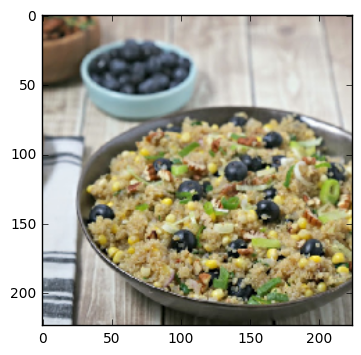

In [25]:
#img_path = 'download.jpg'  # This is an image I took in my kitchen.
j = random.randint(0,len(train_ids))
print(train_ids[j])
img_path = 'resized_thumbs/' + train_ids[j] + '.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

predictions = m.predict(x)

#label_predictions = vgg16.decode_predictions(predictions, top = 10)

conn = sqlite3.connect("yummly.db")
print(conn.execute("SELECT Title FROM Recipe WHERE ID='" + str(train_ids[j]) + "';").fetchone())
conn.close()

print('Input image size:', x.shape)


plt.imshow(np.asarray(img));

print('\nGround truth with Prediction')
for i in range(0,1000):
    if train_labels[j][i] == 1:
        print(id2food[i] + ": " + str(predictions[0][i]))

argsort_results = np.argsort(-predictions)[0]


# print('\nAll Predictions over 10% certainty:')
# for i in range(0,1000):
#     if predictions[0][i] > 0.1:
#         print(id2food[i] + ": " + str(predictions[0][i]))

print("\nTop 20 Predictions")
for i in range(0,20):
    #print(argsort_results[i])
    print(id2food[argsort_results[i]] + ": " + str(predictions[0][argsort_results[i]]))

In [ ]:
len(predictions)

In [ ]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         #shear_range=0.2,
#         #zoom_range=0.2,
#         horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         'images/',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode=None)

# validation_generator = test_datagen.flow_from_directory(
#         'images/',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode=None)

# model.fit_generator(
#         train_generator,
#         samples_per_epoch=2000,
#         nb_epoch=50,
#         validation_data=validation_generator,
#         nb_val_samples=800)